# 1. Connecting to DB and Visualizing the table

In [1]:
import pyodbc
import pandas as pd

server = 'DELL\\SQLEXPRESS'
database = 'NEHADB'

connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;"
conn = pyodbc.connect(connection_string)

query = "SELECT * FROM dbo.Match"
cursor = conn.cursor()
cursor.execute(query)
rows = cursor.fetchall()
columns = [column[0] for column in cursor.description]

df = pd.DataFrame.from_records(rows, columns=columns)
df

,APX_EXT_SEC_ID,APX_RESTR_144A,APX_CNVRT_RATIO,APX_PAYMENT_FREQ,APX_ANNUAL_DIV,CS_EXT_SEC_ID,CS_RESTR_144A,CS_CNVRT_RATIO,CS_PAYMENT_FREQ,CS_ANNUAL_DIV
0,csaeadcb.ae,N,None,A,0.56,csaeadcb.ae,N,None,None,0.56
1,csaeagthia.ae,N,None,S,0.21,csaeagthia.ae,N,None,None,0.21
2,csaeairarabi.ae,N,None,A,0.20,csaeairarabi.ae,N,None,None,0.20
3,csaeajmanban.ae,N,None,A,0.03,csaeajmanban.ae,N,None,None,0.03
4,csaealdar.ae,N,None,A,0.17,csaealdar.ae,N,None,None,0.17
...,...,...,...,...,...,...,...,...,...,...
69829,cshk2209.hk,N,None,A,0.00,None,None,None,None,NaN
69830,cscn301267.c2.cn,N,None,None,0.00,None,None,None,None,NaN
69831,cscn600316.c1.cn,N,None,None,0.00,None,None,None,None,NaN
69832,cscn300571.c2.cn,N,None,A,0.00,None,None,None,None,NaN


# 2. Matching the Table

In [2]:
import pyodbc
import numpy as np
import pandas as pd

server = 'DELL\\SQLEXPRESS'
database = 'NEHADB'
connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;"
conn = pyodbc.connect(connection_string)

query = "SELECT * FROM dbo.Match"
df = pd.read_sql(query, conn)
# Define the tolerance dictionary
tolerance_dict = {
    'int': 1,          
    'date': 1,        
    'float': 0.01      
}

def compare_columns(df, tolerance_dict):
    results = []
    
    for col in df.columns:
        if 'APX_' in col:  
            cs_col = col.replace('APX_', 'CS_')  
            if cs_col in df.columns:  
                dtype = df[col].dtype  

                if dtype == 'object' or df[col].apply(lambda x: isinstance(x, str)).all():
                    comparison = df[col].astype(str).str.strip().fillna('') == df[cs_col].astype(str).str.strip().fillna('')
                
                elif np.issubdtype(dtype, np.integer):
                    comparison = np.abs(df[col] - df[cs_col]) <= tolerance_dict['int']
                
                elif np.issubdtype(dtype, np.floating):
                    comparison = np.abs(df[col] - df[cs_col]) <= tolerance_dict['float']
                
                elif np.issubdtype(dtype, np.datetime64):
                    comparison = np.abs((df[col] - df[cs_col]).dt.days) <= tolerance_dict['date']
                
                else:
                    comparison = pd.Series([None] * len(df))
                
                result = {
                    'Column': col.replace('APX_', ''),  
                    'Matches': comparison.sum(),        
                    'Total': len(comparison),           
                    'Match_Percentage': (comparison.sum() / len(comparison)) * 100  # Match percentage
                }
                results.append(result)
    return pd.DataFrame(results)

comparison_results = compare_columns(df, tolerance_dict)
print(comparison_results)


C:\Users\Neha\AppData\Local\Temp\ipykernel_28184\996454049.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


         Column  Matches  Total  Match_Percentage
0    EXT_SEC_ID    68009  69834         97.386660
1    RESTR_144A    68403  69834         97.950855
2   CNVRT_RATIO    68854  69834         98.596672
3  PAYMENT_FREQ     7818  69834         11.195120
4    ANNUAL_DIV    54003  69834         77.330527


# 3. Visualization of the result

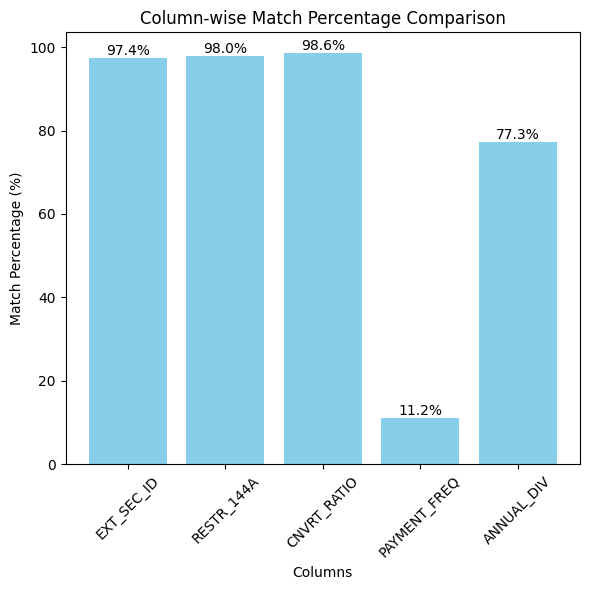

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
bars = plt.bar(comparison_results['Column'], comparison_results['Match_Percentage'], color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Match Percentage (%)')
plt.title('Column-wise Match Percentage Comparison')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()


# 4. Finding the mismatches and exporting the file

In [4]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

server = 'DELL\\SQLEXPRESS'
database = 'NEHADB'
connection_string = f"mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
engine = create_engine(connection_string)

query = "SELECT * FROM dbo.Match"
df = pd.read_sql(query, engine)

tolerance_dict = {
    'int': 1,
    'date': 1,
    'float': 0.01
}

def compare_columns(df, tolerance_dict):
    mismatch_dict = {}
    for col in df.columns:
        if 'APX_' in col:
            cs_col = col.replace('APX_', 'CS_')
            if cs_col in df.columns:
                dtype = df[col].dtype
                if dtype == 'object' or df[col].apply(lambda x: isinstance(x, str)).all():
                    comparison = df[col].astype(str).str.strip().fillna('') == df[cs_col].astype(str).str.strip().fillna('')
                elif np.issubdtype(dtype, np.integer):
                    comparison = np.abs(df[col] - df[cs_col]) <= tolerance_dict['int']
                elif np.issubdtype(dtype, np.floating):
                    comparison = np.abs(df[col] - df[cs_col]) <= tolerance_dict['float']
                elif np.issubdtype(dtype, np.datetime64):
                    comparison = np.abs((df[col] - df[cs_col]).dt.days) <= tolerance_dict['date']
                mismatch_dict[col] = ~comparison
                mismatch_dict[cs_col] = ~comparison
    return mismatch_dict

mismatch_flags = compare_columns(df, tolerance_dict)
mismatch_df = pd.DataFrame(mismatch_flags)

mismatch_rows = df[mismatch_df.any(axis=1)].copy()
match_rows = df[~mismatch_df.any(axis=1)].copy()

cs_columns = [col for col in df.columns if col.startswith('CS_')]
empty_rows = df[df[cs_columns].isnull().all(axis=1)].copy()  # Rows where all CS_ fields are empty

mismatch_rows = mismatch_rows[~mismatch_rows[cs_columns].isnull().all(axis=1)]
match_rows = match_rows[~match_rows['APX_EXT_SEC_ID'].isin(empty_rows['APX_EXT_SEC_ID'])]
mismatch_rows = mismatch_rows[~mismatch_rows['APX_EXT_SEC_ID'].isin(empty_rows['APX_EXT_SEC_ID'])]
match_rows = match_rows[~match_rows['APX_EXT_SEC_ID'].isin(mismatch_rows['APX_EXT_SEC_ID'])]

output_file = r"C:\Users\Neha\Desktop\Output2.xlsx"

try:
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        mismatch_rows.to_excel(writer, sheet_name='Mismatch Table', index=False)
        match_rows.to_excel(writer, sheet_name='Match Table', index=False)
        empty_rows.to_excel(writer, sheet_name='Empty Cells Table', index=False)

        worksheet_mismatch = writer.sheets['Mismatch Table']
        red_fill = PatternFill(start_color="FF0000", end_color="FF0000", fill_type="solid")

        for row in range(2, mismatch_rows.shape[0] + 2):  # Start from row 2
            for col in range(1, mismatch_rows.shape[1] + 1):  # Start from column 1
                if mismatch_df.iloc[row - 2, col - 1]:  # Adjust index for mismatch_df
                    worksheet_mismatch.cell(row=row, column=col).fill = red_fill

        worksheet_empty = writer.sheets['Empty Cells Table']
        yellow_fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")

        for row in range(2, empty_rows.shape[0] + 2):
            for col in range(1, empty_rows.shape[1] + 1):
                if pd.isnull(empty_rows.iloc[row - 2, col - 1]) and 'CS_' in empty_rows.columns[col - 1]:
                    worksheet_empty.cell(row=row, column=col).fill = yellow_fill

except FileNotFoundError:
    print(f"File not found: {output_file}")

print(f"Excel file '{output_file}' has been saved.")


Excel file 'C:\Users\Neha\Desktop\Output2.xlsx' has been saved.
